# Setup

In [ ]:
import zipfile
import matplotlib.pyplot as plt
import random
import collections
import numpy as np
import zipfile
import torch
import os
import torch.nn as nn
import torch.nn.functional as F

from bs4 import BeautifulSoup
import urllib.request
import requests

!pip install pretty_midi
!pip install music21
import pretty_midi
import music21

import pickle
import time
import itertools

!pip install transformers datasets tokenizers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 41.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 4.1 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=58d833f91fd34747729f26b0db94697c255f7dabffd52026312bd0ec7d5bf481
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [ ]:
if torch.cuda.is_available():
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Good to go!


# Huggingface Transformer

[Reference](https://huggingface.co/learn/llm-course/chapter7/6?fw=pt)

In [ ]:
orig_upmat = pickle.load(open('enc_midis_orig.pkl', 'rb'))

orig_mat = [[x-3 for x in row[1:-1]] for row in orig_upmat]

print(orig_upmat[0][:20])

print(orig_mat[0][:20])

[1, 353, 387, 65, 387, 77, 387, 73, 387, 70, 279, 193, 205, 201, 198, 269, 387, 66, 387, 70]
[350, 384, 62, 384, 74, 384, 70, 384, 67, 276, 190, 202, 198, 195, 266, 384, 63, 384, 67, 384]


In [ ]:
trps_upmat = pickle.load(open('enc_midis_trps.pkl', 'rb'))

trps_mat = [[x-3 for x in row[1:-1]] for row in trps_upmat]

print(trps_upmat[0][:20])

print(trps_mat[0][:20])

[1, 353, 387, 74, 387, 70, 387, 67, 387, 62, 279, 202, 198, 195, 190, 269, 387, 72, 387, 67]
[350, 384, 71, 384, 67, 384, 64, 384, 59, 276, 199, 195, 192, 187, 266, 384, 69, 384, 64, 384]


In [ ]:
midi_mat = orig_mat + trps_mat

len(midi_mat)

874

In [ ]:
with open("data_train.txt", "w") as f:
    content = "\n".join(" " + " ".join(str(x) for x in row) for row in midi_mat)
    f.write(content + "\n")

with open("data_valid.txt", "w") as f:
    content = "\n".join(" " + " ".join(str(x) for x in row) for row in midi_mat[:100])
    f.write(content + "\n")

In [ ]:
from datasets import load_dataset

dataset = load_dataset("text", data_files={"train": "data_train.txt", "valid": "data_valid.txt"})

dataset

Generating train split: 0 examples [00:00, ? examples/s]

Generating valid split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 874
    })
    valid: Dataset({
        features: ['text'],
        num_rows: 100
    })
})

In [ ]:
example = dataset["train"]["text"][0][:74]

example

' 350 384 62 384 74 384 70 384 67 276 190 202 198 195 266 384 63 384 67 384'

In [ ]:
from transformers import AutoTokenizer

old_tokenizer = AutoTokenizer.from_pretrained("gpt2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def get_training_corpus():
    return (
        dataset["train"][i : i + 1000]["text"]
        for i in range(0, len(dataset["train"]), 1000)
    )

training_corpus = get_training_corpus()

tokenizer = old_tokenizer.train_new_from_iterator(training_corpus, 52000)

In [ ]:
tokens = tokenizer.tokenize(example)

tokens

['Ġ350',
 'Ġ384',
 'Ġ62',
 'Ġ384',
 'Ġ74',
 'Ġ384',
 'Ġ70',
 'Ġ384',
 'Ġ67',
 'Ġ276',
 'Ġ190',
 'Ġ202',
 'Ġ198',
 'Ġ195',
 'Ġ266',
 'Ġ384',
 'Ġ63',
 'Ġ384',
 'Ġ67',
 'Ġ384']

In [ ]:
context_length = 256

def tokenize(element):
    outputs = tokenizer(
        element["text"],
        truncation=True,
        max_length=context_length,
        return_overflowing_tokens=True,
        return_length=True,
    )
    input_batch = []
    for length, input_ids in zip(outputs["length"], outputs["input_ids"]):
        if length == context_length:
            input_batch.append(input_ids)
    return {"input_ids": input_batch}


tokenized_datasets = dataset.map(
    tokenize, batched=True, remove_columns=dataset["train"].column_names
)
tokenized_datasets

Map:   0%|          | 0/874 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids'],
        num_rows: 27762
    })
    valid: Dataset({
        features: ['input_ids'],
        num_rows: 3256
    })
})

In [ ]:
from transformers import AutoTokenizer, GPT2LMHeadModel, AutoConfig

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=len(tokenizer),
    n_ctx=context_length,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

config

GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 0,
  "embd_pdrop": 0.1,
  "eos_token_id": 0,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 256,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 50
    }
  },
  "transformers_version": "4.55.0",
  "use_cache": true,
  "vocab_size": 587
}

In [ ]:
model = GPT2LMHeadModel(config)
model_size = sum(t.numel() for t in model.parameters())
print(f"GPT-2 size: {model_size/1000**2:.1f}M parameters")

GPT-2 size: 86.3M parameters


In [ ]:
from transformers import DataCollatorForLanguageModeling

tokenizer.pad_token = tokenizer.eos_token
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

data_collator

DataCollatorForLanguageModeling(tokenizer=GPT2TokenizerFast(name_or_path='gpt2', vocab_size=587, model_max_length=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
), mlm=False, mlm_probability=0.15, mask_replace_prob=0.8, random_replace_prob=0.1, pad_to_multiple_of=None, tf_experimental_compile=False, return_tensors='pt', seed=None)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

args = TrainingArguments(
    output_dir="music-generation",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=100,
    gradient_accumulation_steps=16,
    num_train_epochs=20,
    weight_decay=0.05,
    warmup_steps=100,
    lr_scheduler_type="cosine",
    learning_rate=1e-4,
    save_strategy="steps",
    save_steps=100,
    fp16=True,
    push_to_hub=True,
)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
)

trainer

/tmp/ipython-input-2544157073.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

trainer.save_model("./trained_model")

trainer.push_to_hub()

Step,Training Loss,Validation Loss
100,3.723800,2.846041
200,2.464300,1.882864
300,1.833900,1.423398
400,1.501300,1.220333
500,1.312500,1.096608
600,1.189900,1.002815
700,1.098200,0.935333
800,1.030200,0.877875
900,0.976600,0.827585
1000,0.924300,0.775674


No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/metoonhathung/music-generation/commit/e0a6781132a8351ea9cca52b56953d5c199c6a40', commit_message='End of training', commit_description='', oid='e0a6781132a8351ea9cca52b56953d5c199c6a40', pr_url=None, repo_url=RepoUrl('https://huggingface.co/metoonhathung/music-generation', endpoint='https://huggingface.co', repo_type='model', repo_id='metoonhathung/music-generation'), pr_revision=None, pr_num=None)

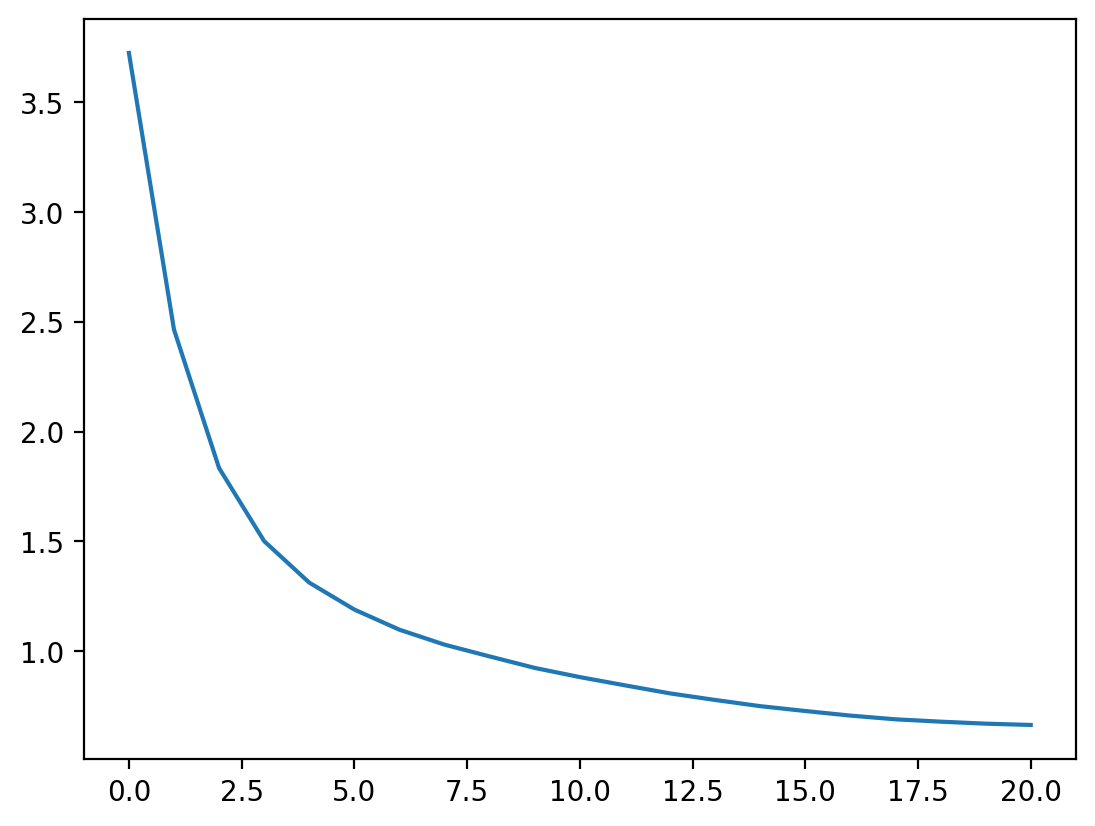

In [ ]:
losses = [x["loss"] for x in trainer.state.log_history if "loss" in x]

plt.plot(losses)
plt.show()

In [ ]:
import torch
from transformers import pipeline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
pipe = pipeline("text-generation", model="./trained_model")
# pipe = pipeline("text-generation", model="metoonhathung/music-generation", device=device)

Device set to use cuda:0


In [ ]:
final_txt = ""
tmp_txt = ""

while len(final_txt.split(" ")) < 2048:
  res_txt = pipe(tmp_txt, num_return_sequences=1, max_new_tokens=256)[0]["generated_text"]
  final_txt = final_txt.replace(tmp_txt, res_txt)
  res_lst = [int(x) for x in res_txt.split(" ")[1:]]
  tmp_txt = " " + " ".join([str(x) for x in res_lst[-32:]])
  print("len =", len(final_txt.split(" ")))

final_lst = [int(x) for x in final_txt.split(" ")[1:]]

final_txt

len = 257


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


len = 513
len = 769
len = 1025
len = 1281
len = 1537
len = 1793
len = 2049


' 378 84 378 76 378 72 272 212 204 200 378 86 378 74 378 77 272 214 202 205 378 84 378 76 378 72 272 212 204 200 272 378 77 378 81 378 65 272 205 209 193 272 378 76 378 84 378 72 378 67 272 204 212 200 195 272 378 83 378 77 378 62 272 211 205 190 272 378 86 378 77 378 67 378 71 272 214 205 195 199 272 378 83 378 77 378 67 378 71 272 211 205 195 199 378 86 272 214 378 83 378 77 378 67 378 71 272 211 205 195 199 378 86 272 214 378 83 378 77 378 67 378 71 272 211 205 195 199 272 378 79 378 76 378 60 378 72 272 207 204 188 200 272 378 81 378 93 378 72 378 64 378 67 272 209 221 200 192 195 272 382 91 382 83 382 95 382 55 382 67 272 219 211 223 183 195 272 382 84 382 93 382 96 382 67 382 72 382 64 272 212 221 224 195 200 192 272 382 88 382 100 382 60 382 72 272 216 228 188 200 382 93 382 88 382 84 382 64 382 52 272 221 216 212 192 180 272 382 93 382 81 382 72 382 67 382 64 272 221 209 200 195 192 382 84 272 212 382 88 382 52 382 64 272 216 180 192 382 93 382 81 382 88 272 221 209 216 382 51 

In [ ]:
def download_processor(file_name):
  if not os.path.exists(file_name):
    DATA_URL = 'https://raw.githubusercontent.com/jason9693/midi-neural-processor/master/processor.py'
    r = requests.get(DATA_URL)

    with open(file_name, 'w') as f:
      f.write(r.text)

download_processor('processor.py')

In [ ]:
from processor import encode_midi, decode_midi

decode_midi(final_lst, 'output.midi')

info removed pitch: 25
info removed pitch: 25
